# Import libraries

In [1]:
# import libraries
import random
import numpy as np
import pandas as pd
import math 
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler

import scipy
from scipy.spatial.distance import pdist, squareform
from scipy.stats import chi2
import time

import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.font_manager
plt.style.use(['ggplot'])

# Data preprocessing

In [3]:
# Import the dataset
# The dataset is Highway-Rail Grade Crossing Accident dataset
# Importing the dataset, Highway-Rail Grade Crossing Accident dataset
data = pd.read_csv('Highway-Rail_Grade_Crossing_Accident_Data.csv', low_memory=False)
print("Original data shape:", data.shape)

# Count accidents by unique company pairs
grouped_data = data.groupby(['Railroad Code', 'Incident Year', 'State Name', 'Highway User Position', 'Equipment Involved']).size().reset_index(name='Accident Count')
print("Grouped data shape:", grouped_data.shape)

# Merge the 'Accident Count' column back into the original data
merged_data = pd.merge(data, grouped_data, on=['Railroad Code', 'Incident Year', 'State Name', 'Highway User Position', 'Equipment Involved'], how='left')
print("Merged data shape:", merged_data.shape)

# Define features and target variable
categorical_features = ['Highway User Position', 'Equipment Involved']
numeric_features = ['Incident Year']
target = 'Accident Count'

# Drop rows with missing values in the target variable
merged_data.dropna(subset=[target], inplace=True)

# Convert 'Incident Year' to full year format
merged_data['Incident Year'] = merged_data['Incident Year'].apply(lambda year: 2000 + year if year <= 21 else 1900 + year)

# Define X and y
X = merged_data[numeric_features + categorical_features]
y = merged_data[target]
y = np.reshape(y, (len(y), 1))

# Convert categorical features to numerical data
ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), categorical_features)], remainder='passthrough')
X_transformed = ct.fit_transform(X).toarray()

sample_size = int(X_transformed.shape[0] * .5)  

rows_id = random.sample(range(X_transformed.shape[0]), sample_size)
X_1 = X_transformed[rows_id, :]
y1 = y[rows_id]

print("The size of X_1 after sampling is {}".format(X_1.shape))
print("The size of y1 after sampling is {}".format(y1.shape))

Original data shape: (239487, 141)
Grouped data shape: (52706, 6)
Merged data shape: (239487, 142)
The size of X_1 after sampling is (119542, 19)
The size of y1 after sampling is (119542, 1)


In [4]:
# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_1, y1, test_size = 0.2, random_state = 0)
print("The size of training data is {}".format(X_train.shape))
print("The size of test data is {}".format(X_test.shape))

The size of training data is (95633, 19)
The size of test data is (23909, 19)


In [5]:
# Normalize the data (fiting the scaler on the training data only)
scaler_X = MinMaxScaler().fit(X_train)
scaler_y = MinMaxScaler().fit(y_train)
X_train_scaled = scaler_X.transform(X_train)
y_train_scaled = scaler_y.transform(y_train)
X_test_scaled = scaler_X.transform(X_test)
y_test_scaled = scaler_y.transform(y_test)

# Train model

In [6]:
train_X, train_Y = X_train_scaled.T, y_train_scaled.T
test_X, test_Y = X_test_scaled.T, y_test_scaled.T

In [7]:
def rf_map(X, L, sigma):
    # L:  number of random features
    np.random.seed(1)
    d,_ = X.shape
    #generate multivariate normal distribution
    Mu = np.zeros(d)     # zero mean     
    Sigma = 1/(sigma**2) * np.eye(d)  # covariance matrix
    Omega = np.random.multivariate_normal(Mu, Sigma, L)
    b = np.random.uniform(0, 2*np.pi, (L, 1))
    Phi_X = math.sqrt(2/L) * np.cos(np.dot(Omega, X) + b)
    return Phi_X, Omega, b

In [8]:
def compute_cost(yhat, y):
    """
    yhat is the output from fully connected layer (num_classes*num_examples)
    y is labels (num_classes*num_examples, y is one-hot encoded vector)
    """
    m = y.shape[1]  #num_examples
    diff  = y - yhat
    loss = (1/2/m) * np.sum(np.square(diff))   
    return loss

In [9]:
np.random.seed(1)
lr = 2
lambd = 1e-4
L = 200
sigma = 3

# Initialize parameters
train_costs_RF = []
test_MSE_RF =[]
theta_RF = np.zeros((1, L)) 

#RF mapping
Phi_train, Omega1, b1 = rf_map(train_X, L, sigma)
Phi_test, Omega1, b1 = rf_map(test_X, L, sigma)

start = time.perf_counter()
for i in range(0, 300):
    trainY_RF = np.dot(theta_RF, Phi_train)
    testY_RF = np.dot(theta_RF, Phi_test)
    
    # Calculate cost
    train_cost_RF = compute_cost(trainY_RF, train_Y) + np.sum(np.square(theta_RF))*lambd/2 
    test_mse_RF = compute_cost(testY_RF, test_Y) 
    
    # Calculate gradient
    diff_RF = trainY_RF - train_Y
    grad_RF = (1/train_Y.shape[1]) * np.dot(diff_RF, Phi_train.T) + lambd*theta_RF
    
    # Update parameters
    theta_RF = theta_RF - lr*grad_RF
    
    train_costs_RF.append(train_cost_RF)
    test_MSE_RF.append(test_mse_RF)

test_rmse = math.sqrt(test_MSE_RF[-1])  # Compute RMSE

end = time.perf_counter()
trf = end - start
print("The process takes %.4f seconds " %(trf))
print("Train cost is " + str(train_costs_RF[-1]))
print("Test MSE is " + str(test_MSE_RF[-1]))
print("Test RMSE is " + str(test_rmse))

The process takes 1.6124 seconds 
Train cost is 0.00717179354797892
Test MSE is 0.00731100695656135
Test RMSE is 0.08550442653197173


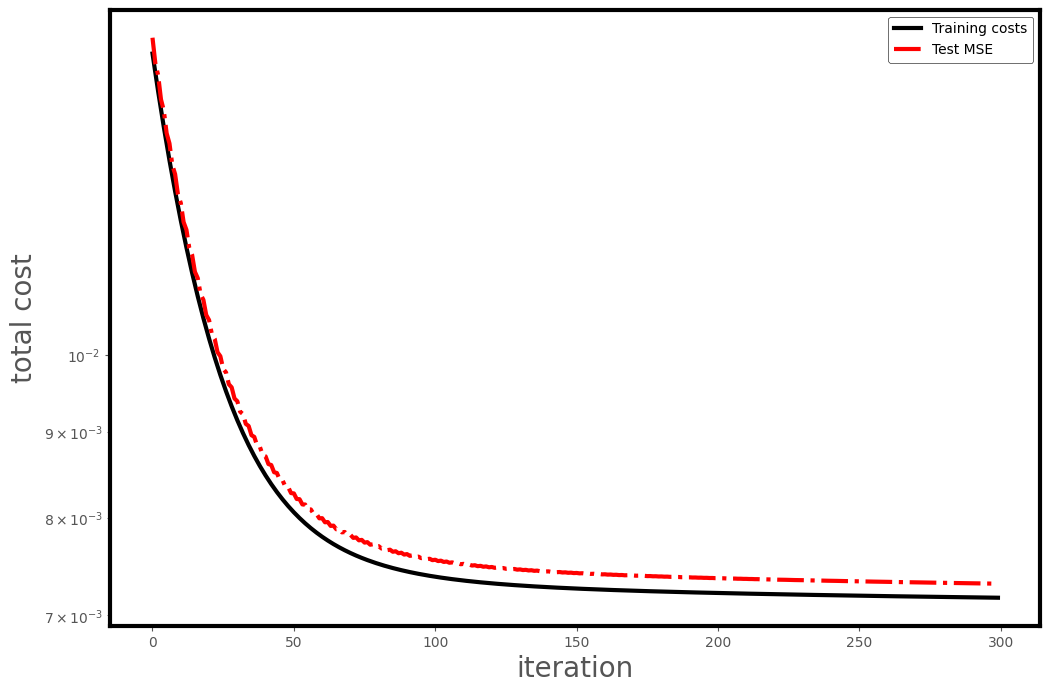

In [10]:
plt.figure(figsize=((12,8)))
matplotlib.rc('axes', edgecolor='black', linewidth=3, fc = 'white')
plt.rc('xtick',labelsize=10)
plt.rc('ytick',labelsize=10)
plt.plot(train_costs_RF, 'k-', linewidth=3, label="Training costs")
plt.plot(test_MSE_RF, 'r-.', linewidth=3, label="Test MSE")

plt.legend(edgecolor = 'black',  handlelength = 2, fontsize=10)
plt.ylabel('total cost',fontsize=20)
plt.xlabel('iteration',fontsize=20)
plt.yscale('log')
plt.show()  